In [78]:
from qiskit import *
from qiskit.circuit import Parameter,ParameterVector
from qiskit.quantum_info import Operator
from qiskit.circuit.library import *
from qiskit.visualization import array_to_latex, plot_histogram
from qutip import hilbert_dist, Qobj, fock_dm

import random

import pyswarms as ps
import pyswarms.backend as P
from pyswarms.backend.topology import Star

import numpy as np

First, lets take a look at the Toffoli gate

In [3]:
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
backend = BasicAer.get_backend('unitary_simulator')
job = backend.run(transpile(qc, backend))
ccx_gate = job.result().get_unitary(qc, decimals=2)
array_to_latex(ccx_gate)

2023-02-21 23:42:10,472 - qiskit.transpiler.runningpassmanager - INFO - Pass: ContainsInstruction - 0.01764 (ms)
2023-02-21 23:42:10,474 - qiskit.transpiler.runningpassmanager - INFO - Pass: UnitarySynthesis - 0.00620 (ms)
2023-02-21 23:42:10,478 - qiskit.transpiler.runningpassmanager - INFO - Pass: HighLevelSynthesis - 0.37885 (ms)
2023-02-21 23:42:10,481 - qiskit.transpiler.runningpassmanager - INFO - Pass: UnrollCustomDefinitions - 0.12040 (ms)
2023-02-21 23:42:10,484 - qiskit.transpiler.passes.basis.basis_translator - INFO - Begin BasisTranslator from source basis {('ccx', 3)} to target basis {'delay', 'snapshot', 'measure', 'sx', 'u3', 'x', 'id', 'rz', 'barrier', 'u1', 'reset', 'unitary', 'u2', 'cx'}.
2023-02-21 23:42:10,489 - qiskit.transpiler.passes.basis.basis_translator - INFO - Basis translation path search completed in 0.003s.
2023-02-21 23:42:10,496 - qiskit.transpiler.passes.basis.basis_translator - INFO - Basis translation paths composed in 0.006s.
2023-02-21 23:42:10,497

<IPython.core.display.Latex object>

We can use the Hilbert Schmitt distance from the qutip library to get the hilbert distance between this and itself. Which of course will be 0

In [4]:
def get_hilbert_shmidt_distance(gate1, gate2):
    return hilbert_dist(Qobj(gate1), Qobj(gate2))

def my_hilbert_schmidt_distance(gate1, gate2):
    return np.sqrt(1 - (np.abs(np.trace(np.conj(gate1).T @ gate2))**2) / (2**3)**2)

In [5]:
print("Hilbert Schmidt Distance of CCX with itself: ", get_hilbert_shmidt_distance(ccx_gate, ccx_gate))
print("My Hilbert Schmidt Distance of CCX with itself: ", my_hilbert_schmidt_distance(ccx_gate, ccx_gate))

Hilbert Schmidt Distance of CCX with itself:  0.0
My Hilbert Schmidt Distance of CCX with itself:  0.0


In [63]:
class SingleQubitU(Gate):
    def __init__(self, theta, phi, lam):
        super().__init__('U1', 1, [theta, phi, lam])
    
    def _define(self):
        qc = QuantumCircuit(1)
        qc.unitary(self.to_matrix(), [0])
        self.definition = qc
    
    def to_matrix(self):
        theta = float(self.params[0])
        phi = float(self.params[1])
        lam = float(self.params[2])
        return UGate(theta, phi, lam).to_matrix()
        # return np.array([[np.cos(theta/2), -np.exp(1.j * lam) * np.sin(theta/2)],
        #                  [np.exp(1.j * phi) * np.sin(theta/2), np.exp(1.j * (phi + lam)) * np.cos(theta/2)]])

In [64]:
class TwoQubitU(Gate):
    def __init__(self, alpha1, alpha2, alpha3):
        super().__init__('U2', 2, [alpha1, alpha2, alpha3])
    def _define(self):
        qc = QuantumCircuit(2)
        qc.unitary(self.to_matrix(), [0, 1])
        self.definition = qc
    def to_matrix(self):
        alpha1 = float(self.params[0])
        alpha2 = float(self.params[1])
        alpha3 = float(self.params[2])

        rxx_gate = RXXGate(alpha1).to_matrix()
        ryy_gate = RYYGate(alpha2).to_matrix()
        rzz_gate = RZZGate(alpha3).to_matrix()
        return rxx_gate @ ryy_gate @ rzz_gate 

        # return np.array([[np.cos(alpha1/2), 0, 0, -np.exp(1.j * alpha3) * np.sin(alpha1/2)],
        #                  [0, np.cos(alpha2/2), -np.exp(1.j * alpha3) * np.sin(alpha2/2), 0],
        #                  [0, -np.exp(1.j * alpha3) * np.sin(alpha2/2), np.cos(alpha2/2), 0],
        #                  [-np.exp(1.j * alpha3) * np.sin(alpha1/2), 0, 0, np.cos(alpha1/2)]])
    

In [65]:
class ParamVectorItterator:
    def __init__(self, param_vector):
        self.param_vector = param_vector
        self.index = 0
    def __iter__(self):
        return self
    def __next__(self):
        if self.index < len(self.param_vector):
            start = self.index
            end = self.index + 3
            params = self.param_vector[start:end]
            self.index += 3
            return params
        else:
            raise StopIteration

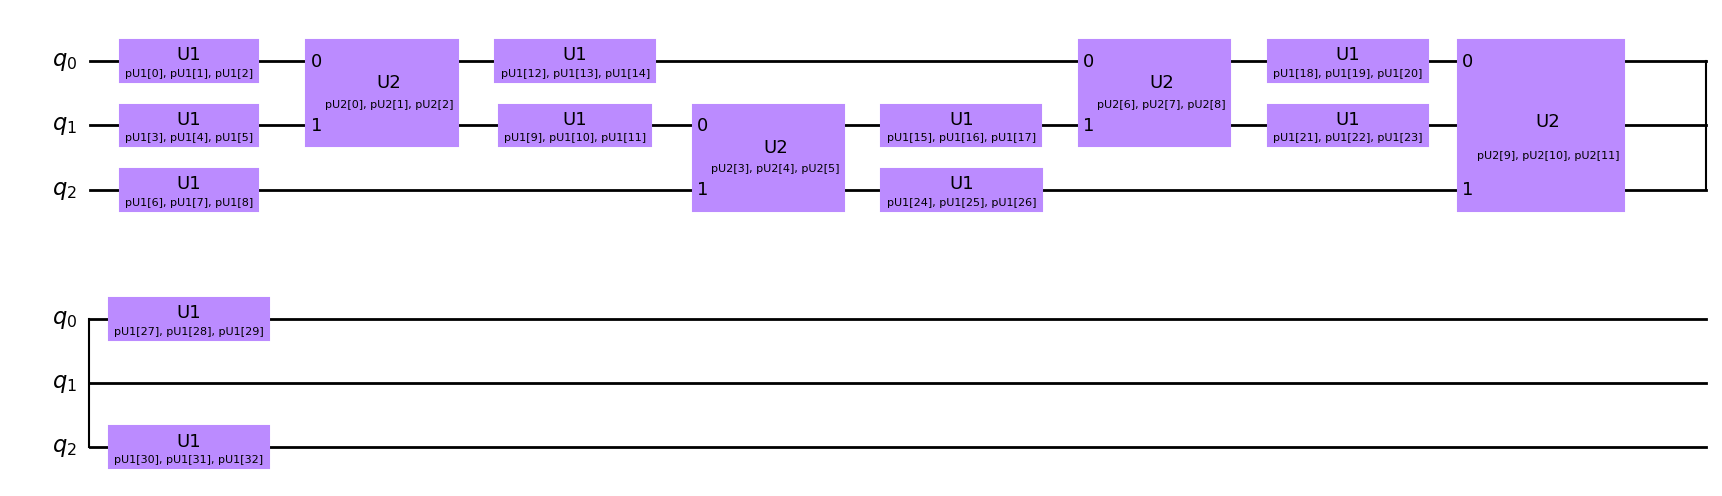

In [66]:
approx_CCNOT_qc = QuantumCircuit(3, name="Approx CCNOT")

# Define parameters
theta = Parameter('theta')
phi = Parameter('phi')
lam = Parameter('lam')

num_U1_params = 3 * 11
num_U2_params = 3 * 4

pU1 = ParameterVector('pU1', num_U1_params)
pU1_itter = ParamVectorItterator(pU1)
pU2 = ParameterVector('pU2', num_U2_params)
pU2_itter = ParamVectorItterator(pU2)

# Create the circuit
i = 0
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [0])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [1])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [2])

approx_CCNOT_qc.append(TwoQubitU(*next(pU2_itter)), [0, 1])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [1])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [0])
approx_CCNOT_qc.append(TwoQubitU(*next(pU2_itter)), [1, 2])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [1])

approx_CCNOT_qc.append(TwoQubitU(*next(pU2_itter)), [0, 1])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [0])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [1])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [2])

approx_CCNOT_qc.append(TwoQubitU(*next(pU2_itter)), [0, 2])

approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [0])
approx_CCNOT_qc.append(SingleQubitU(*next(pU1_itter)), [2])

approx_CCNOT_qc.draw(output='mpl')

In [67]:
def opt_func(vals):
    distances = []
    for p in vals:
        # Get the circuit
        bound_approx_CCNOT = approx_CCNOT_qc.bind_parameters({pU1: p[:num_U1_params], pU2: p[num_U1_params:]})

        # Get the matrix
        approx_CCNOT_matrix = Operator(bound_approx_CCNOT).data

        # Get the distance
        distances.append(my_hilbert_schmidt_distance(ccx_gate, approx_CCNOT_matrix))

    return distances

In [81]:
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
bounds = (np.repeat(0, num_U1_params + num_U2_params), np.repeat(2*np.pi, num_U1_params + num_U2_params))
init_pos = np.array([best_pos_thus_far for _ in range(250)])
optimizer = ps.single.GlobalBestPSO(n_particles=250, dimensions=num_U1_params + num_U2_params, options=options, bounds=bounds)
cost, pos = optimizer.optimize(opt_func, iters=2500)

print("Total cost: ", cost)
print("Best position: ", pos)

2023-02-22 01:24:55,188 - pyswarms.single.global_best - INFO - Optimize for 2500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|2500/2500, best_cost=0.4  
2023-02-22 01:51:01,533 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.40029853768527124, best pos: [3.34348164 3.07273385 1.80918787 1.86142114 2.69048959 2.75856882
 2.6966173  3.98877677 4.48119064 1.30269057 3.1924323  3.57432923
 3.11916873 2.31955996 3.14207827 2.97143851 3.95714758 3.67429452
 2.74768071 2.79130706 3.14695887 3.26647049 1.86623073 5.28498969
 3.59729151 2.60593143 4.53867312 3.43628764 2.5265043  3.11791517
 3.22077869 3.29784085 1.59540476 3.86019144 4.4044914  5.39163988
 4.75421775 4.41644388 2.34500316 3.44966995 3.86272276 2.96784368
 1.51685901 3.35502147 3.15006652]


Total cost:  0.40029853768527124
Best position:  [3.34348164 3.07273385 1.80918787 1.86142114 2.69048959 2.75856882
 2.6966173  3.98877677 4.48119064 1.30269057 3.1924323  3.57432923
 3.11916873 2.31955996 3.14207827 2.97143851 3.95714758 3.67429452
 2.74768071 2.79130706 3.14695887 3.26647049 1.86623073 5.28498969
 3.59729151 2.60593143 4.53867312 3.43628764 2.5265043  3.11791517
 3.22077869 3.29784085 1.59540476 3.86019144 4.4044914  5.39163988
 4.75421775 4.41644388 2.34500316 3.44966995 3.86272276 2.96784368
 1.51685901 3.35502147 3.15006652]


In [82]:
best_pos_thus_far = pos

bound_approx_CCNOT = approx_CCNOT_qc.bind_parameters({pU1: best_pos_thus_far[:num_U1_params], pU2: best_pos_thus_far[num_U1_params:]})
array_to_latex
print(f"Best params so far: {best_pos_thus_far}")

Best params so far: [3.34348164 3.07273385 1.80918787 1.86142114 2.69048959 2.75856882
 2.6966173  3.98877677 4.48119064 1.30269057 3.1924323  3.57432923
 3.11916873 2.31955996 3.14207827 2.97143851 3.95714758 3.67429452
 2.74768071 2.79130706 3.14695887 3.26647049 1.86623073 5.28498969
 3.59729151 2.60593143 4.53867312 3.43628764 2.5265043  3.11791517
 3.22077869 3.29784085 1.59540476 3.86019144 4.4044914  5.39163988
 4.75421775 4.41644388 2.34500316 3.44966995 3.86272276 2.96784368
 1.51685901 3.35502147 3.15006652]


In [53]:
topology = Star()
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
bounds = (np.repeat(0, num_U1_params + num_U2_params), np.repeat(np.pi, num_U1_params + num_U2_params))
swarm = P.create_swarm(n_particles=50, dimensions=num_U1_params + num_U2_params, options=options, bounds=bounds)
swarm.position = np.array([pos for _ in range(50)])

In [54]:
itterations = 1000
for i in range(itterations):
    # Set currebt and best cost
    swarm.current_cost = opt_func(swarm.position)
    swarm.pbest_cost = opt_func(swarm.pbest_pos)
    # Update and store
    swarm.pbest_pos, swarm.pbest_cost = P.compute_pbest(swarm)

    # Step 2 - Update the global best
    if np.min(swarm.pbest_cost) < swarm.best_cost:
        swarm.best_pos, swarm.best_cost = topology.compute_gbest(swarm)


    if i%10 == 0:
        print(f"Iteration: {i}, Best Cost: {swarm.best_cost}")
    
    # Step 3 - Update velocity and position matrices
    swarm.velocity = topology.compute_velocity(swarm)
    swarm.position = topology.compute_position(swarm)
    
print(f"Best Cost: {swarm.best_cost}")
print(f"Best Position: {swarm.best_pos}")

IndexError: invalid index to scalar variable.

In [83]:

vals = np.repeat(np.pi/3, num_U1_params + num_U2_params)
bound_qc = approx_CCNOT_qc.bind_parameters({pU1: vals[:num_U1_params], pU2: vals[num_U1_params:]})